In [5]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [6]:
env = BlackjackEnv()

In [7]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [18]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        A = np.zeros(len(Q[observation]))
        A_star = np.argmax(Q[observation])
        A[A_star] = 1.0
        return A
    return policy_fn

In [19]:
def generate_sequence(policy):
    Episode=[]
    notEndOfEpisode=True
    S=env.reset()
    while notEndOfEpisode:
        pi = policy(S)
        A = np.random.choice(np.arange(len(pi)), p=pi)
        S_next, R, Criteria, _ = env.step(A)
        Episode.append((S,A,R))
        if notEndOfEpisode==Criteria:
            notEndOfEpisode=False
        S=S_next
    return Episode

In [20]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # initialization
    
    # Action value function
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Cumulative sum 
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Arbritrary target policy
    target_policy = create_greedy_policy(Q)
    
    for j in range(0,num_episodes):
        
        # generate sequence for episode following b
        sequence=generate_sequence(behavior_policy)
        
        # Sum of discounted returns
        G = 0.0
        # The weights
        W = 1.0
        # Loop for each step of episode, t = T −1, ..., 0, while W != 0:
        for time_step in range(len(sequence))[::-1]:
            
            S,A,R  = sequence[time_step]
            
            G = discount_factor * G + R
            
            C[S][A] += W
           
            Q[S][A] += (W / C[S][A]) * (G - Q[S][A])
          
            if A !=  np.argmax(target_policy(S)):
                break
            W = W * 1./behavior_policy(S)[A]
                
    return Q, target_policy

In [21]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

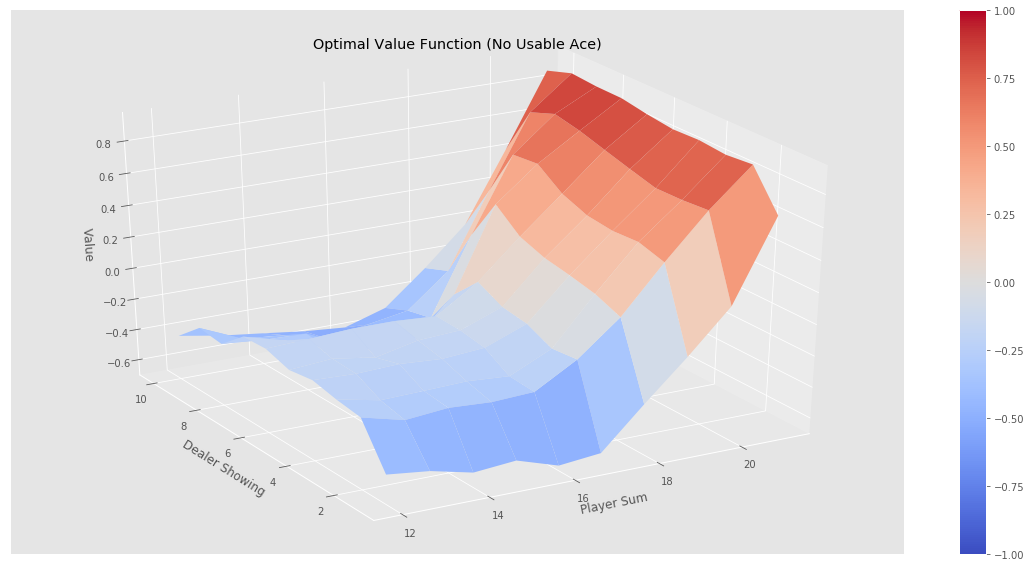

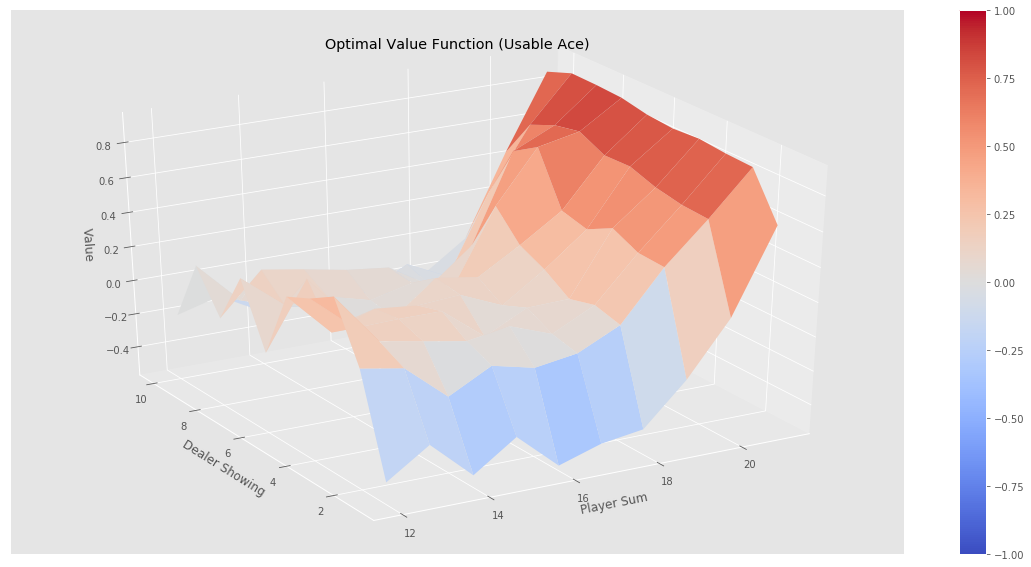

In [22]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")